In [1]:
# Generate synthetic CPU usage data
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

# Set seed for reproducibility
np.random.seed(42)

# Generate a date range
date_range = pd.date_range(start='2022-01-01', end='2024-02-01', freq='h')

# Generate synthetic cpu_usage data
cpu_usage = np.random.rand(len(date_range)) * 50 + 50  # Random values between 0 and 100

# Create a DataFrame
synthetic_data = pd.DataFrame({'timestamp': date_range, 'cpu_usage': cpu_usage})

# Save to SQLite database
engine = create_engine('sqlite:///synthetic_cpu_usage.db')
synthetic_data.to_sql('cpu_usage', engine, index=False, if_exists='replace')

print("Synthetic dataset generated and saved to 'synthetic_cpu_usage.db'")


Synthetic dataset generated and saved to 'synthetic_cpu_usage.db'


In [3]:
# Import the required libraries
import numpy as np
import pandas as pd
from keras import Sequential
from keras.api.layers import Input, LSTM, Dense, Dropout
from keras.api.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import os

In [5]:
%load_ext sql
%sql sqlite:////kaggle/working/synthetic_cpu_usage.db

In [6]:
# Step 1: Data Collection & Preparation
try:
    # Connect to SQLite database and load data
    data = %sql SELECT * FROM cpu_usage
    data = data.DataFrame()

    # Convert timestamp column to datetime
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)

    # Validate data frame content and types
    if not all([col in data.columns for col in ['cpu_usage']]):
        raise ValueError("DataFrame does not contain required columns 'cpu_usage'")

    if not pd.api.types.is_numeric_dtype(data['cpu_usage']):
        raise TypeError("Column 'cpu_usage' must be numeric")

except Exception as e:
    print(f"Error loading data: {e}")
    raise

 * sqlite:////kaggle/working/synthetic_cpu_usage.db
Done.


Epoch 1/50
456/457 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1035
Epoch 1: saving model to Model_ckpt.weights.h5
457/457 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1035 - val_loss: 0.0830
Epoch 2/50
454/457 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0847
Epoch 2: saving model to Model_ckpt.weights.h5
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0847 - val_loss: 0.0817
Epoch 3/50
454/457 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0853
Epoch 3: saving model to Model_ckpt.weights.h5
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0854 - val_loss: 0.0818
Epoch 4/50
456/457 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0845
Epoch 4: saving model to Model_ckpt.weights.h5
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0845 - val_loss: 0.0827
Epoch 5/50
453/457 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0847
Epoch 5: saving model to Model_ckpt.weights.h5
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0847 - val_loss: 0.0816
Epoch 6/50
456/457 ━━━━━━━━━━━━━━━━━━━━ 0s 10

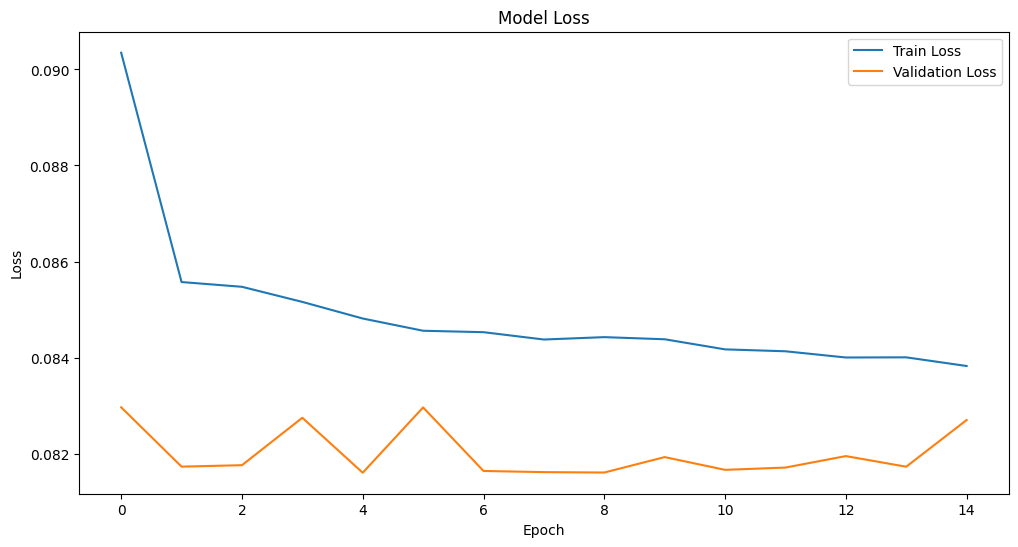

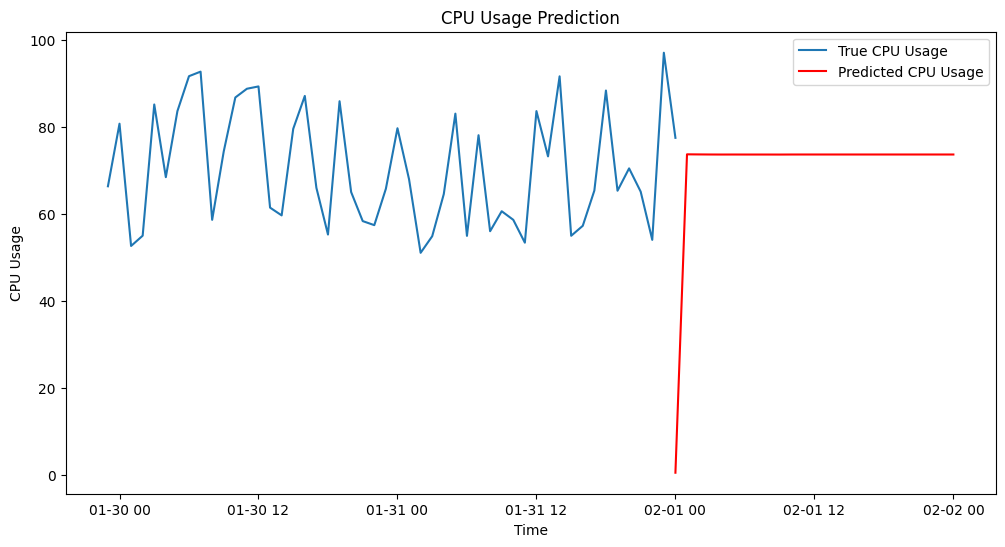

In [7]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['cpu_usage']])

# Create sequences for LSTM
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM input

# Step 2: Training the LSTM Model
# Split data into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# # Define the LSTM model
# def create_lstm_model(input_shape):
#     model = Sequential()
#     model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
#     model.add(Dropout(0.2))
#     model.add(LSTM(50))
#     model.add(Dropout(0.2))
#     model.add(Dense(1))

#     model.compile(optimizer='adam', loss='mse')
#     return model

# Define the LSTM model with Input layer
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Using Input layer
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    return model


#checkpoint_path = "cp-{epoch:04d}.ckpt"
checkpoint_path = "Model_ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, save_freq='epoch')

# Setup early stopping with patience of 10 epochs
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# # Create and train the model
# lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
# history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
#                          callbacks=[early_stopping_callback, cp_callback])

# Create and train the model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                         callbacks=[early_stopping_callback, cp_callback])


# Step 3: Making Predictions
def predict_future_cpu(model, recent_data, scaler, steps=24):
    predictions = []
    input_data = recent_data[-10:]

    for _ in range(steps):  # Predict for the next 24 steps (hours)
        input_data_reshaped = input_data.reshape((1, 10, 1))  # Reshape for model input
        prediction = model.predict(input_data_reshaped)
        predictions.append(prediction[0][0])

        input_data = np.append(input_data[1:], prediction[0][0])
        input_data = input_data.reshape((10, 1))  # Ensure proper shape for next iteration

    scaled_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return scaled_predictions.flatten()

# Predict future CPU usage for the next 24 hours
future_cpu_usage = predict_future_cpu(lstm_model, scaled_data, scaler, steps=24)

# Step 4: Visualization
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index[-50:], scaler.inverse_transform(scaled_data[-50:]), label='True CPU Usage')
plt.plot(pd.date_range(data.index[-1], periods=25, freq='h'), np.append(scaled_data[-1], future_cpu_usage),
         label='Predicted CPU Usage', color='red')
plt.title('CPU Usage Prediction')
plt.ylabel('CPU Usage')
plt.xlabel('Time')
plt.legend(loc='upper right')
plt.show()